In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [13]:
CSV_FILEPATH = 'postgres/20210925-084713_grab_cut_mask.csv'
IMG_SHAPE = (384, 512)

In [14]:
df = pd.read_csv(CSV_FILEPATH)

In [15]:
df.dtypes

id                      object
session_id              object
image_id                object
mask                    object
interactionrecord_id    object
dtype: object

In [16]:
def idx_str_to_np_array(x):
    indices = [int(s) for s in x.split(',')]
    mask_array = np.empty(IMG_SHAPE, dtype=np.uint8).ravel()
    mask_array.fill(0)
    mask_array[indices] = 1
    return mask_array.reshape(IMG_SHAPE)
    
df['mask_np_arr'] = df['mask'].apply(idx_str_to_np_array)

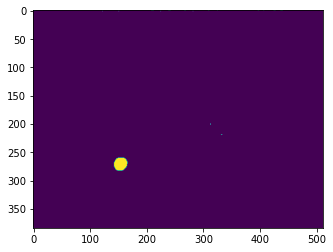

In [18]:
plt.imshow(df.iloc[0]['mask_np_arr'])

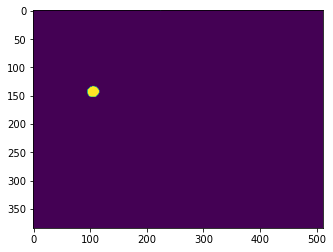

In [28]:
plt.imshow(df.loc[df['id'] == '35175266-08d3-4fa9-b3eb-203d54b9f1bb', 'mask_np_arr'].values[0])